In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
torch.backends.cudnn.benchmark=True
import time

from adamw import AdamW
from scheduler import Scheduler
from models import *

In [ ]:
import torch.distributed as dist
import torch.utils.data.distributed
from torch.nn.parallel import DistributedDataParallel

In [3]:
PATH = Path('../fastai_docs/data')
MODEL_PATH = PATH/'models'
MODEL_PATH.mkdir(exist_ok=True)
save_tag = 'imagenet_magenta'

In [ ]:

if args.distributed:
    log.console('Distributed initializing process group')
    torch.cuda.set_device(args.local_rank)
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url, world_size=env_world_size())
    assert(env_world_size() == dist.get_world_size())
    print("Distributed: success (%d/%d)"%(args.local_rank, dist.get_world_size()))


In [90]:

IMAGENET_PATH = Path('../data/imagenet-sz/160/train')
train_ds = ImageClassificationDataset.from_folder(IMAGENET_PATH)

# size,bs = 96,36
size,bs = 128,32
# size,bs = 256,20

# Content Data
data_norm,data_denorm = normalize_funcs(*imagenet_stats)
train_tds = DatasetTfm(train_ds, tfms=[crop_pad(size=size, is_random=False)], tfm_y=False, size=size, do_crop=True)

data_sampler = DistributedSampler(train_tds, num_replicas=env_world_size(), rank=env_rank()) if env_world_size() > 1 else None
train_dl = DeviceDataLoader.create(train_tds, tfms=data_norm, num_workers=8, bs=bs, shuffle=(data_sampler is None), sampler=data_sampler)
# data = DataBunch.create(train_tds, valid_ds=None, bs=bs, tfms=data_norm, sampler=data_sampler)

# Style Data

# STYLE_PATH = PATH/'style/dtd/images'
STYLE_PATH = PATH/'style/dtd/subset'
style_ds = ImageClassificationDataset.from_folder(STYLE_PATH)

# STYLE_PATH = PATH/'style/pbn/train'
# style_ds = ImageClassificationDataset.from_single_folder(STYLE_PATH, ['train'])

style_tds = DatasetTfm(style_ds, tfms=[crop_pad(size=size, is_random=False)], tfm_y=False, size=size, do_crop=True)
style_dl = DeviceDataLoader.create(style_tds, tfms=data_norm, num_workers=8, bs=1, shuffle=True)
# style_data = DataBunch.create(style_tds, valid_ds=None, bs=1, tfms=data_norm)
# style_data.valid_dl = None

### Distributed

In [91]:
from torch.utils.data.distributed import DistributedSampler

def reduce_tensor(tensor): return sum_tensor(tensor)/env_world_size()
def sum_tensor(tensor):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    return rt

def env_world_size(): return int(os.environ.get('WORLD_SIZE', 1))
def env_rank(): return int(os.environ.get('RANK',0))

In [92]:
# losses
def ct_loss(input, target): return F.mse_loss(input,target)

def gram(input):
        b,c,h,w = input.size()
        x = input.view(b, c, -1)
        return torch.bmm(x, x.transpose(1,2))/(c*h*w)

def gram_loss(input, target): return F.mse_loss(gram(input), gram(target))

def tva_loss(y):
    w_var = torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:]))
    h_var = torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))
    return w_var + h_var

## Create models

In [93]:
mt = StyleTransformer()
ms = StylePredict.create_inception()
m_com = CombinedModel(mt, ms).cuda()

In [ ]:
if args.distributed: 
    m_com = DistributedDataParallel(m_com, device_ids=[args.local_rank], output_device=args.local_rank)
    m_vgg = DistributedDataParallel(m_vgg, device_ids=[args.local_rank], output_device=args.local_rank)

In [94]:
m_vgg = VGGActivations().cuda()

Layer ids:  [12, 22, 32, 42]


### Set params

In [95]:
epochs = 3
log_interval = 50

optimizer = AdamW(m_com.parameters(), lr=1e-5, betas=(0.9,0.999), weight_decay=1e-5)

In [96]:
scheduler = Scheduler(optimizer, [{'ep': (0,1), 'lr': (1e-5,5e-4)}, 
                                  {'ep': (1,2), 'lr': (5e-4,1e-5)},  
                                  {'ep': (2,epochs), 'lr': (1e-5,1e-7)}])

In [97]:
# m_com.load_state_dict(torch.load(MODEL_PATH/f'model_combined_4_imagenet_256.pth'), strict=False)
# m_com.load_state_dict(torch.load(MODEL_PATH/f'model_combined_{save_tag}.pth'), strict=True)

In [100]:
style_wgts = [i*1e9 for i in [5,50,5,.5]] # 2,3,4,5
c_block = 1 # 1=3
ct_wgt = 1e3
tva_wgt = 5e-6

In [101]:

start = time.time()
m_com.train()
style_image_count = 0
for e in range(epochs):
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_tva_loss = 0.
    count = 0
    batch_tot = len(train_dl)
    for batch_id, (x_con,_) in enumerate(train_dl):
        scheduler.update_lr(e, batch_id, batch_tot)
        
#         if (batch_id % (log_interval*3) == 0):
        try:
            x_style,_ = next(it_style)
        except:
            it_style = iter(style_dl)
            x_style,_ = next(it_style)
            print('Restarting style')
        style_image_count += 1
            
        with torch.no_grad(): 
            style_batch = x_style.repeat(bs,1,1,1)
            s_out = m_vgg(style_batch)
            style_feat = [s.clone() for s in s_out]
            
            targ_feat = m_vgg(x_con)[c_block].clone()
            
        n_batch = x_con.size(0)
        count += n_batch
        optimizer.zero_grad()
        
        out = m_com(x_con, x_style)
        out,_ = data_norm((out,None))
        inp_feat = m_vgg(out)
        
        closs = [ct_loss(inp_feat[c_block],targ_feat) * ct_wgt]
        sloss = [gram_loss(inp,targ)*wgt for inp,targ,wgt in zip(inp_feat, style_feat, style_wgts) if wgt > 0]
        tvaloss = tva_loss(out) * tva_wgt
        
        total_loss = closs + sloss + [tvaloss]
        total_loss = sum(total_loss)
    
        total_loss.backward()
#         nn.utils.clip_grad_norm_(m_com.m_tran.parameters(), 10)
#         nn.utils.clip_grad_norm_(m_com.m_style.parameters(), 80)
        optimizer.step()
    
        mom = 0.9
        agg_content_loss = agg_content_loss*mom + sum(closs).detach().data*(1-mom)
        agg_style_loss = agg_style_loss*mom + sum(sloss).detach().data*(1-mom)
        agg_tva_loss = agg_tva_loss*mom + tvaloss.detach().data*(1-mom)
        agg_total_loss = (agg_content_loss + agg_style_loss + agg_tva_loss)
        
        if (batch_id + 1) % log_interval == 0:
            time_elapsed = (time.time() - start)/60
            mesg = "Min:{:.3f}\tEp{}: [{}/{}]\tcontent: {:.3f}\tstyle: {:.3f}\ttva: {:.3f}\ttotal: {:.3f}\t simg: {}".format(
                time_elapsed, e + 1, count, len(train_dl)*bs,
                              agg_content_loss,
                              agg_style_loss,
                              agg_tva_loss,
                              agg_total_loss,
                              style_image_count
            )
            print(mesg)
        
            

Restarting style
Changing LR from 1e-05 to 1.001223867922172e-05
Min:0.140	Ep1: [1600/1281184]	content: 22.624	style: 119.130	tva: 2.780	total: 144.534	 simg: 50
Min:0.256	Ep1: [3200/1281184]	content: 22.900	style: 226.198	tva: 2.887	total: 251.985	 simg: 100
Min:0.371	Ep1: [4800/1281184]	content: 22.949	style: 119.946	tva: 2.835	total: 145.730	 simg: 150
Min:0.487	Ep1: [6400/1281184]	content: 22.612	style: 106.301	tva: 2.838	total: 131.750	 simg: 200
Min:0.602	Ep1: [8000/1281184]	content: 22.692	style: 179.537	tva: 2.935	total: 205.165	 simg: 250
Min:0.718	Ep1: [9600/1281184]	content: 22.512	style: 154.905	tva: 3.134	total: 180.551	 simg: 300
Min:0.833	Ep1: [11200/1281184]	content: 22.617	style: 83.390	tva: 3.170	total: 109.177	 simg: 350
Min:0.949	Ep1: [12800/1281184]	content: 22.880	style: 199.184	tva: 2.995	total: 225.059	 simg: 400
Min:1.064	Ep1: [14400/1281184]	content: 22.879	style: 113.453	tva: 3.030	total: 139.362	 simg: 450
Restarting style
Min:1.191	Ep1: [16000/1281184]	cont

Min:9.588	Ep1: [131200/1281184]	content: 21.632	style: 151.967	tva: 4.103	total: 177.702	 simg: 4100
Min:9.703	Ep1: [132800/1281184]	content: 22.142	style: 94.000	tva: 3.762	total: 119.903	 simg: 4150
Min:9.819	Ep1: [134400/1281184]	content: 21.544	style: 93.416	tva: 4.392	total: 119.352	 simg: 4200
Min:9.934	Ep1: [136000/1281184]	content: 21.510	style: 80.429	tva: 4.279	total: 106.218	 simg: 4250
Min:10.050	Ep1: [137600/1281184]	content: 21.847	style: 165.610	tva: 3.980	total: 191.437	 simg: 4300
Restarting style
Min:10.177	Ep1: [139200/1281184]	content: 21.652	style: 123.288	tva: 4.692	total: 149.632	 simg: 4350
Min:10.292	Ep1: [140800/1281184]	content: 21.506	style: 130.436	tva: 4.372	total: 156.313	 simg: 4400
Min:10.408	Ep1: [142400/1281184]	content: 21.763	style: 118.783	tva: 4.283	total: 144.829	 simg: 4450
Min:10.523	Ep1: [144000/1281184]	content: 21.791	style: 244.241	tva: 4.571	total: 270.604	 simg: 4500
Min:10.639	Ep1: [145600/1281184]	content: 21.840	style: 125.370	tva: 4.0

KeyboardInterrupt: 

In [62]:
def eval_imgs(x_con, x_style, idx=0):
    with torch.no_grad(): 
        out = m_com(x_con, x_style)
    fig, axs = plt.subplots(1,3,figsize=(12,4))
    Image(data_denorm(x_con[idx].cpu())).show(axs[0])
    axs[0].set_title('Content')
    axs[1].set_title('Style')
    axs[2].set_title('Transfer')
    Image(data_denorm(x_style[0].cpu())).show(axs[1])
    Image((out[idx].detach().cpu())).show(axs[2])
    

In [63]:
x_con,_ = next(iter(train_dl))

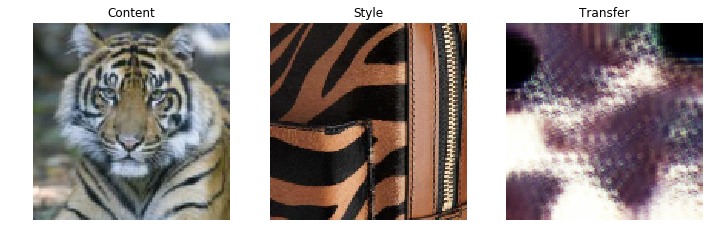

In [65]:
x_style,_ = next(iter(style_dl))
eval_imgs(x_con, x_style)

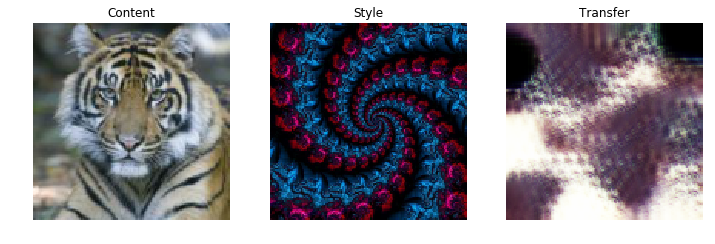

In [66]:
x_style,_ = next(iter(style_dl))
eval_imgs(x_con, x_style)